In [1]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
tf.__version__

'2.15.0'

In [2]:
# To solve the error when downloading the dataset, run the command below before import
!sed -i 's/# Download FTP/url = url.replace("people.eecs.berkeley.edu\/~taesung_park\/CycleGAN\/datasets", "efrosgans.eecs.berkeley.edu\/cyclegan\/datasets") # Download FTP/' /usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/download/downloader.py

In [ ]:
!pip install tensorflow-datasets

In [14]:
import tensorflow_datasets as tfds

In [4]:
!apt remove git -y -

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git git-lfs
0 upgraded, 0 newly installed, 2 to remove and 32 not upgraded.
After this operation, 29.4 MB disk space will be freed.
(Reading database ... 121749 files and directories currently installed.)
Removing git-lfs (3.0.2-1ubuntu0.2) ...
Removing git (1:2.34.1-1ubuntu1.10) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-email git-gui gitk gitweb git-cvs
  git-mediawiki git-svn
The following NEW packages will be installed:
  git
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 3,166 kB of archives.
After this operation, 18.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 git amd64 1:2.34.1-1ubuntu1.10 [3,166 kB]
Fetched 3,166 kB in 1s (2,267 kB/s)
Selecting previously unselected package git.
(Reading database ... 120910 files and directories currently installed.)
Preparing to unpack .../git_1%3a2.34.1-1ubuntu1.10_amd64.deb ...
Unpacking git (1:2.34.1-1ubuntu1.10) ...
Setting up git (1:2.34.1-1ubuntu1.10) ...
Cloning into 'examples'...
remote: Enumerating objects: 23737, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressi

In [6]:
tf.random.set_seed(789)

DATASET

In [27]:
dataset, metadata = tfds.load('cycle_gan/apple2orange', with_info = True, as_supervised = True)

In [28]:
dataset

{'trainA': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'trainB': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'testA': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'testB': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [41]:
train_A , train_B =  dataset['trainA'], dataset['trainB']
test_A , test_B = dataset['testA'], dataset['testB']

In [42]:
dataset_size = len(train_A)
dataset_size

995

In [31]:
BUFFER_SIZE = dataset_size
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGT = 256

PREPROCESSING

In [32]:
def random_crop(img):
  img_crop = tf.image.random_crop(img, size = [IMG_WIDTH, IMG_HEIGT, 3])
  return img_crop

In [33]:
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

In [34]:
def random_jitter(img):
  img = tf.image.resize(img, [286, 286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = random_crop(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [35]:
def process_training_img(img, label):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [36]:
def process_test_img(img, label):
  img = normalize(img)
  return img

LOADING DATASET

In [43]:
train_A = train_A.cache().map(process_training_img, num_parallel_calls = tf.data.AUTOTUNE) .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B = train_B.cache().map(process_training_img, num_parallel_calls = tf.data.AUTOTUNE) .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [44]:
test_A = test_A.cache().map(process_test_img, num_parallel_calls = tf.data.AUTOTUNE) .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B = test_B.cache().map(process_test_img, num_parallel_calls = tf.data.AUTOTUNE) .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [50]:
sample_A = next(iter(train_A))
sample_B = next(iter(train_B))

Apple


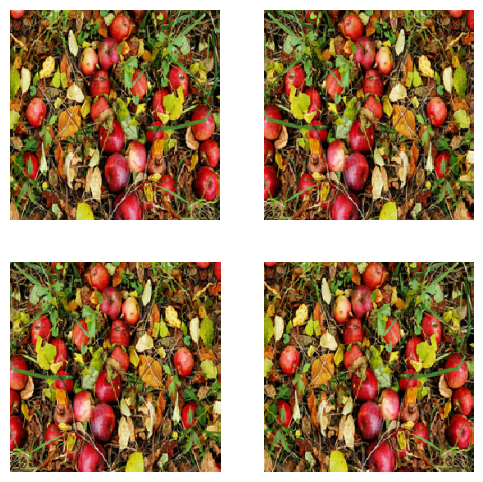

In [56]:
print('Apple')
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = random_jitter(sample_A[0])
  plt.subplot(2,2,i+1)
  #plt.imshow(sample_A[0] * 0.5 + 0.5)
  plt.imshow(A_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

Orange


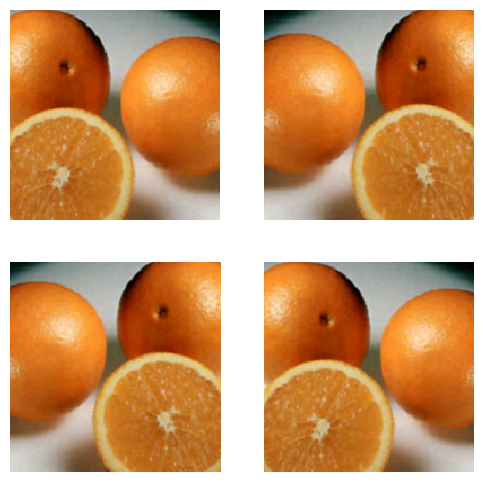

In [57]:
print('Orange')
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = random_jitter(sample_B[0])
  plt.subplot(2,2,i+1)
  #plt.imshow(sample_A[0] * 0.5 + 0.5)
  plt.imshow(A_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

GENERATOR AND DISCRIMINATOR

## Generator and Discriminator

1. *Instance normalization* is used instead of *batch normalization*
2. The generator is a modified ResNet - we are going to use U-net so the implementation will be simpler



In [58]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

In [59]:
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type = 'instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type = 'instancenorm')
discriminator_x = pix2pix.discriminator(norm_type = 'instancenorm', target = False)
discriminator_y = pix2pix.discriminator(norm_type = 'instancenorm', target = False)

CycleGAN algorithm:

* There are 2 generators (G e F) and 2 discriminators (X e Y)

1. Generator G = learn how to convert image X into image Y (`G:X->Y`)
2. Generator F = learn how to convert image Y into image X  (`F:Y->X`)
3. Discriminator D_X = learn how to classify image X and image X generated by the generator(`X(F(Y))`)
4. Discriminator D_Y = learn how to classify image Y and image Y generated by the generator (`Y(G(X))`)

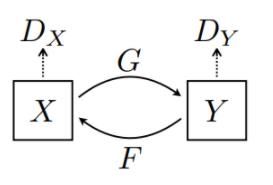

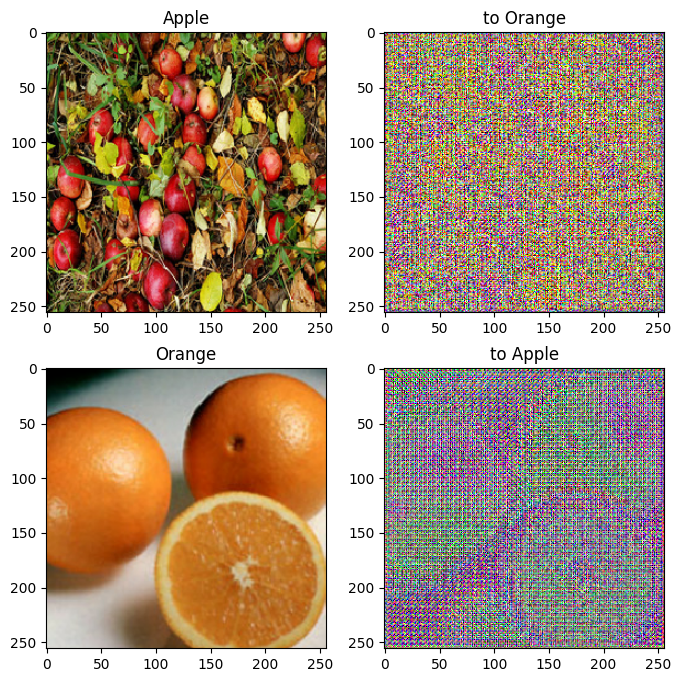

In [60]:
B_generated = generator_g(sample_A) # apple -> orange
A_generated = generator_f(sample_B) # orange -> apple
plt.figure(figsize = (8,8))
imgs = [sample_A, B_generated, sample_B, A_generated]
title = ['Apple', 'to Orange', 'Orange', 'to Apple']
for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * 6 + 0.5)
plt.show()

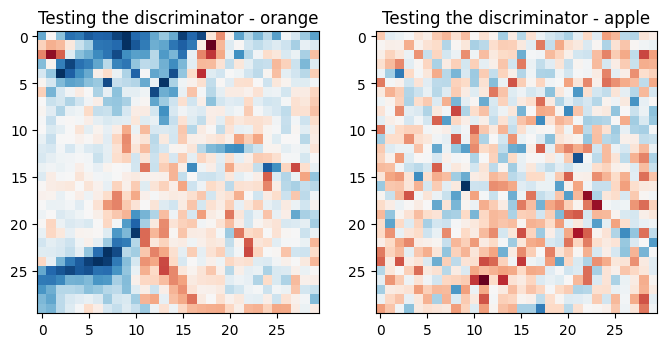

In [61]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.title('Testing the discriminator - orange')
plt.imshow(discriminator_y(sample_B)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(1, 2, 2)
plt.title('Testing the discriminator - apple')
plt.imshow(discriminator_x(sample_A)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

LOSS

* Unlike Pix2Pix, when implementing CycleGAN we don't have a paired training set, so there's no guarantee that the input image X and the reference image Y are similar.

* To ensure that the network learns to do the correct mapping, the authors proposed the cycle consistency loss (*cycle consistency loss*)

In [62]:
LAMBDA = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [63]:
def discriminator_loss(real, generated):
  real_loss = loss(tf.ones_like(real), real)
  generated_loss = loss(tf.zeros_like(generated), generated)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

In [64]:
def generator_loss(generated):
  return loss(tf.ones_like(generated), generated)

> Cycle consistency loss - means that the result should be close to the original (input) image. Example: if we translate a sentence from Portuguese to English, and then translate it again from English to Portuguese, the result must be the same as the original sentence.

Steps:

* Image X is sent to generator G that creates image Y^
* Generated image Ŷ is sent to generator F that creates image X^ "cycled"
* Mean Absolute Error is calculated between X e X^


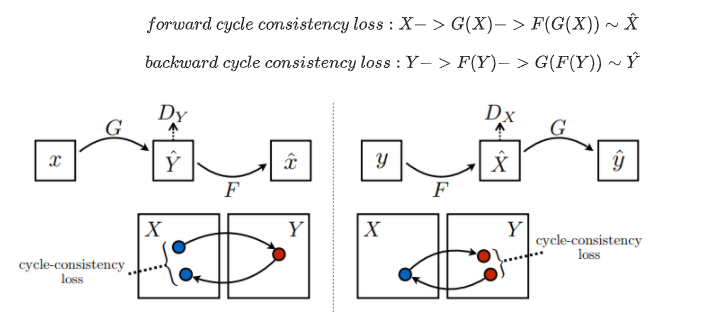

In [65]:
def cycle_loss(real_img, cycled_img):
  loss1 = tf.reduce_mean(tf.abs(real_img - cycled_img)) # MAE
  return LAMBDA * loss1

In short:

* Generator G is responsible for translating image X to Y

* Identity loss: if you send Y image to the generator G, it should generate image Y or something similar to image Y

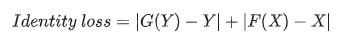

In [67]:
def identity_loss(real_img, equal_img):
  loss = tf.reduce_mean(tf.abs(real_img - equal_img))
  return LAMBDA * 0.5 * loss

More about identity loss
* https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/322
* https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/pull/362

OPTIMIZERS

In [68]:
LEARNING_RATE = 0.0002
BETA1, BETA2 = 0.5, 0.999

In [70]:
optimizer_generator_g = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = BETA1, beta_2 = BETA2)
optimizer_generator_f = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = BETA1, beta_2 = BETA2)

optimizer_discriminator_x = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = BETA1, beta_2 = BETA2)
optimizer_discriminator_y = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = BETA1, beta_2 = BETA2)

In [71]:
checkpoint_dir = "/content/checkpoints/train"
checkpoint = tf.train.Checkpoint(generator_g = generator_g,
                                 generator_f = generator_f,
                                 discriminator_x = discriminator_x,
                                 discriminator_y = discriminator_y,
                                 generator_g_optimizer=optimizer_generator_g,
                                 generator_f_optimizer = optimizer_generator_f,
                                 discriminator_x_optimizer = optimizer_discriminator_x,
                                 discriminator_y_optimizer = optimizer_discriminator_y)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoing)
  print('Latest checkpoint restored!')

TRAIN

In [72]:
EPOCHS = 10
def generate_images(model, test_input):
  generated = model(test_input)
  plt.figure(figsize = (8,6))
  list_imgs = [test_input[0], generated[0]]
  title = ['Original', 'Output (generated)']
  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(list_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [73]:
@tf.function
def training_step(real_x, real_y): # apple, orange
  with tf.GradientTape(persistent=True) as tape:
    # Generator G: X -> Y
    # Generator F: Y -> X

    # Apple into an orange fake
    fake_y = generator_g(real_x, training = True)
    # Cycle (apple into orange, orange into apple fake) x -> y -> x
    cycled_x = generator_f(fake_y, training = True)

    # Orange into an apple fake
    fake_x = generator_f(real_y, training = True)
    # Cycle (orange into apple fake, apple into orange fake) y -> x -> y
    cycled_y = generator_g(fake_x, training = True)

    # Identity mapping
    equal_x = generator_f(real_x, training = True)
    equal_y = generator_g(real_y, training = True)

    # Discriminator outputs
    discriminator_real_x = discriminator_x(real_x, training = True)
    discriminator_fake_x = discriminator_x(fake_x, training = True)
    discriminator_real_y = discriminator_y(real_y, training = True)
    discriminator_fake_y = discriminator_y(fake_y, training = True)

    # Loss calculation
    generator_g_loss = generator_loss(discriminator_fake_y)
    generator_f_loss = generator_loss(discriminator_fake_x)
    cycle_loss_total = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
    total_generator_g_loss = generator_g_loss + cycle_loss_total + identity_loss(real_y, equal_y)
    total_generator_f_loss = generator_f_loss + cycle_loss_total + identity_loss(real_x, equal_x)
    discriminator_x_loss = discriminator_loss(discriminator_real_x, discriminator_fake_x)
    discriminator_y_loss = discriminator_loss(discriminator_real_y, discriminator_fake_y)

  # Gradients
  generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)

  # Optimizer
  optimizer_generator_g.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  optimizer_generator_f.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  optimizer_discriminator_x.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  optimizer_discriminator_y.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [74]:
def train(training_A, training_B, generator_g, steps):
  for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for img_x, img_y in tf.data.Dataset.zip((training_A, training_B)):
      training_step(img_x, img_y)
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    clear_output(wait = True)
    generate_images(generator_g, sample_A)
    print('Time taken to train epoch {}: {} seconds\n'.format(epoch + 1, time.time() - start))

    if (epoch + 1) % 5 == 0:
      checkpoint_dir_saved = checkpoint_manager.save()
      print('Checkpoint saved')

    generator_g.save_weights('model_cyclegan.h5')

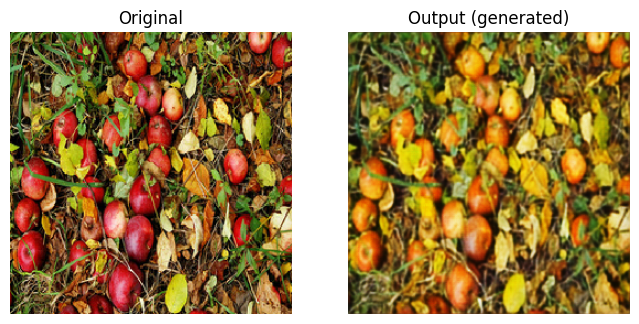

Time taken to train epoch 10: 441.1934862136841 seconds

Checkpoint saved


In [75]:
train(train_A, train_B, generator_g, EPOCHS)

In [77]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

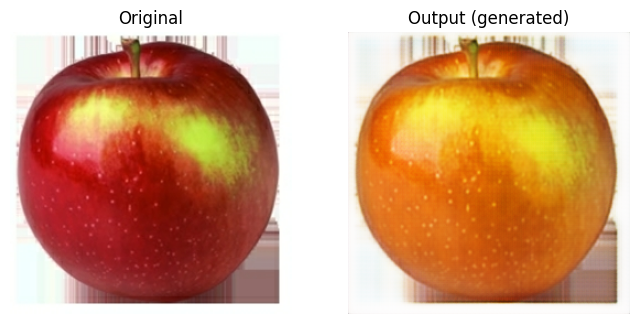

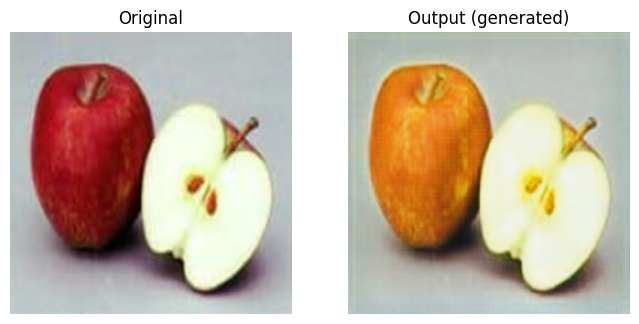

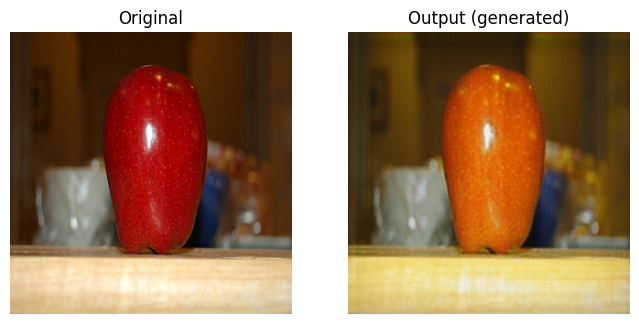

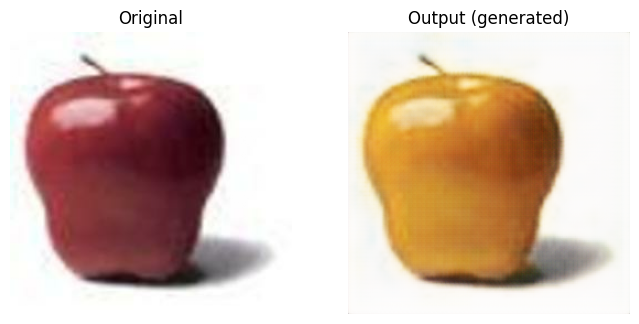

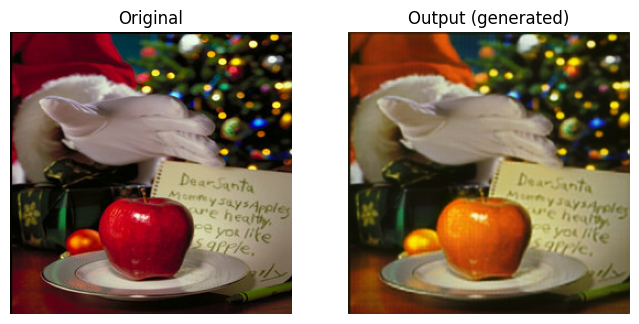

In [78]:
for input in test_A.take(5):
  generate_images(generator_g, input)

References:
* https://github.com/keras-team/keras-io/blob/master/examples/generative/ipynb/cyclegan.ipynb
* https://keras.io/examples/generative/cyclegan/